# Capstone project - Caribbean restaurants in New York

### Author: Matej Kuchar

## Introduction

Caribbean cuisine is a fusion of African, Creole, Cajun, Amerindian, European, Latin American, Indian/South Asian, Middle Eastern, and Chinese. These traditions were brought from many different countries when they came to the Caribbean. In addition, the population has created styles that are unique to the region. (Source: https://en.wikipedia.org/wiki/Caribbean_cuisine)

## Business Goal Description

The client wants to expand his network of caribbean restaurants to New York City and is asking to analyze and recommend a few neighborhoods in NY with low density of caribbean restaurants to open a restaurant in.

## Data

For information about the venues, Foursquare API, category "Caribbean Restaurant" (ID 4bf58dd8d48988d144941735) will be used. https://developer.foursquare.com/docs/build-with-foursquare/categories/

Dataset which contains the New York borroughs and neighborhoods with their latitudes and longitudes will be used. The dataset can be found in the NYU Spatial Data Repository pages: https://geo.nyu.edu/catalog/nyu_2451_34572

## Methodology

Dataset containing New York borroughs and neighboorhoods with their latitudes and longitudes was used and converted into Pandas dataframe. After that using Foursquare API and Folium map, New York neighboorhoods were explored for their density of caribbean restaurants. Finally using k-means clustering the neighborhoods in New York were divided to 5 clusters based on the density of caribbean restaurants.

## Importing Libraries

In [3]:
import pandas as pd
import numpy as np
from geopy.geocoders import Nominatim
import json
import requests
from pandas.io.json import json_normalize
from sklearn.cluster import KMeans
import folium
import matplotlib.cm as cm
import matplotlib.colors as colors

## Download and explore dataset

Download json file

In [4]:
import urllib
from urllib.request import urlopen

url = "https://cocl.us/new_york_dataset"

response = urllib.request.urlopen(url)

newyork_data = json.loads(response.read())

newyork_data

{'type': 'FeatureCollection',
 'totalFeatures': 306,
 'features': [{'type': 'Feature',
   'id': 'nyu_2451_34572.1',
   'geometry': {'type': 'Point',
    'coordinates': [-73.84720052054902, 40.89470517661]},
   'geometry_name': 'geom',
   'properties': {'name': 'Wakefield',
    'stacked': 1,
    'annoline1': 'Wakefield',
    'annoline2': None,
    'annoline3': None,
    'annoangle': 0.0,
    'borough': 'Bronx',
    'bbox': [-73.84720052054902,
     40.89470517661,
     -73.84720052054902,
     40.89470517661]}},
  {'type': 'Feature',
   'id': 'nyu_2451_34572.2',
   'geometry': {'type': 'Point',
    'coordinates': [-73.82993910812398, 40.87429419303012]},
   'geometry_name': 'geom',
   'properties': {'name': 'Co-op City',
    'stacked': 2,
    'annoline1': 'Co-op',
    'annoline2': 'City',
    'annoline3': None,
    'annoangle': 0.0,
    'borough': 'Bronx',
    'bbox': [-73.82993910812398,
     40.87429419303012,
     -73.82993910812398,
     40.87429419303012]}},
  {'type': 'Feature',
 

Transform into dataframe

In [5]:
neighborhoods_data = newyork_data['features']

# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

In [6]:
neighborhoods.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


Let's check how many neighboorhoods and boroughs the dataset has:

In [7]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(neighborhoods['Borough'].unique()),
        neighborhoods.shape[0]
    )
)

The dataframe has 5 boroughs and 306 neighborhoods.


Let's get the geographical coorodinates of New York.

In [8]:
address = 'New York City, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of New York City are 40.7127281, -74.0060152.


And now visualize map of New York and its neighboorhoods with Folium library.

In [9]:
# create map of New York using latitude and longitude values
map_newyork = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Borough'], neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)  
    
map_newyork

Now let's setup Foursquare API credentials:

In [10]:
CLIENT_ID = '5TZXNYW3ZN0VYRON1CSJCB3GKR5JRYPGRGD3BXRVY1PBSBI1' # your Foursquare ID
CLIENT_SECRET = 'LA5PHHGOSHGWJISYABWRHJ4CZVGAAWBT2HVRB5A4I5BJEFYG' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

Create function to explore venues.

In [11]:
def getNearbyVenues(names, latitudes, longitudes, radius=5000, categoryIds=''):
    try:
        venues_list=[]
        for name, lat, lng in zip(names, latitudes, longitudes):
            #print(name)

            # create the API request URL
            url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, VERSION, lat, lng, radius, LIMIT)

            if (categoryIds != ''):
                url = url + '&categoryId={}'
                url = url.format(categoryIds)

            # make the GET request
            response = requests.get(url).json()
            results = response["response"]['venues']

            # return only relevant information for each nearby venue
            for v in results:
                success = False
                try:
                    category = v['categories'][0]['name']
                    success = True
                except:
                    pass

                if success:
                    venues_list.append([(
                        name, 
                        lat, 
                        lng, 
                        v['name'], 
                        v['location']['lat'], 
                        v['location']['lng'],
                        v['categories'][0]['name'],
                     )])

        nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
        nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude',  
                  'Venue Category',
                                      ]
    
    except:
        print(url)
        print(response)
        print(results)
        print(nearby_venues)

    return(nearby_venues)

Let's set limits and radius for each neighborhood:

In [12]:
LIMIT = 500 
radius = 5000

And now let's get the data of New York's caribbean restaurants:

In [13]:
ny_restaurants = getNearbyVenues(names=neighborhoods['Neighborhood'],
                                 latitudes=neighborhoods['Latitude'],
                                 longitudes=neighborhoods['Longitude'],
                                 radius=1000,
                                 categoryIds='4bf58dd8d48988d144941735'
                                )
ny_restaurants.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Wakefield,40.894705,-73.847201,Cooler Runnings Jamaican Restaurant Inc,40.898083,-73.850259,Caribbean Restaurant
1,Wakefield,40.894705,-73.847201,Ali's Roti Shop,40.894036,-73.856935,Caribbean Restaurant
2,Wakefield,40.894705,-73.847201,La Montego,40.891052,-73.858332,Caribbean Restaurant
3,Wakefield,40.894705,-73.847201,Top Choice,40.898501,-73.855340,Caribbean Restaurant
4,Wakefield,40.894705,-73.847201,Jackie's West Indian Bakery,40.889283,-73.843310,Caribbean Restaurant


Let's check how many venues were returned for each neighborhood.

In [14]:
ny_restaurants.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Allerton,10,10,10,10,10,10
Arlington,1,1,1,1,1,1
Arverne,1,1,1,1,1,1
Astoria,4,4,4,4,4,4
Battery Park City,12,12,12,12,12,12
...,...,...,...,...,...,...
Windsor Terrace,1,1,1,1,1,1
Wingate,48,48,48,48,48,48
Woodhaven,8,8,8,8,8,8


Now let's visualize the restaurants.

In [15]:
# create map of New York restaurants using latitude and longitude values
map_restaurants = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, neighborhood in zip(ny_restaurants['Venue Latitude'], ny_restaurants['Venue Longitude'], ny_restaurants['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_restaurants)  
    
map_restaurants

Let's compare number of neighborhoods in New York and how many of them have a caribbean restaurant.

In [16]:
print('There are {} neighborhoods in New York, yet only in {} there is a caribbean restaurant.'
      .format(neighborhoods.shape[0], ny_restaurants.groupby('Neighborhood').count().shape[0]))

There are 306 neighborhoods in New York, yet only in 207 there is a caribbean restaurant.


In [19]:
ny_restaurants_grouped = ny_restaurants.groupby('Neighborhood').count().reset_index()
ny_restaurants_grouped = ny_restaurants_grouped.drop(columns=['Neighborhood Latitude', 'Neighborhood Longitude', 'Venue Latitude', 'Venue Longitude', 'Venue Category'])
ny_restaurants_grouped

,Neighborhood,Venue
0,Allerton,10
1,Arlington,1
2,Arverne,1
3,Astoria,4
4,Battery Park City,12
...,...,...
202,Windsor Terrace,1
203,Wingate,48
204,Woodhaven,8
205,Woodlawn,11


Set number of clusters to 5.

In [21]:
kclusters = 5

ny_grouped_clustering = ny_restaurants_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(ny_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([0, 2, 2, 2, 0, 0, 2, 2, 4, 2], dtype=int32)

Add the cluster label coords.

In [22]:
ny_restaurants_grouped.insert(0, 'Cluster Labels', kmeans.labels_)
ny_restaurants_grouped


,Cluster Labels,Neighborhood,Venue
0,0,Allerton,10
1,2,Arlington,1
2,2,Arverne,1
3,2,Astoria,4
4,0,Battery Park City,12
...,...,...,...
202,2,Windsor Terrace,1
203,1,Wingate,48
204,0,Woodhaven,8
205,0,Woodlawn,11


In [24]:
ny_merged = neighborhoods.merge(ny_restaurants_grouped, on='Neighborhood')
ny_merged


,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,Venue
0,Bronx,Wakefield,40.894705,-73.847201,3,21
1,Bronx,Co-op City,40.874294,-73.829939,0,7
2,Bronx,Eastchester,40.887556,-73.827806,0,11
3,Bronx,Fieldston,40.895437,-73.905643,2,1
4,Bronx,Kingsbridge,40.881687,-73.902818,2,5
...,...,...,...,...,...,...
205,Manhattan,Hudson Yards,40.756658,-74.000111,0,7
206,Queens,Hammels,40.587338,-73.805530,2,3
207,Queens,Bayswater,40.611322,-73.765968,2,1
208,Queens,Queensbridge,40.756091,-73.945631,2,5


Explore how many venues are in each cluster.

In [25]:
ny_merged['Cluster Labels'].value_counts()

2    93
0    64
3    36
1     9
4     8
Name: Cluster Labels, dtype: int64

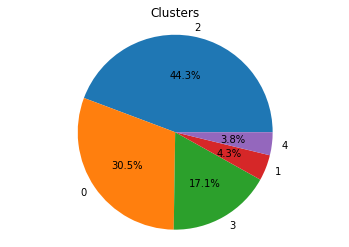

In [43]:
import matplotlib.pyplot as plt

labels = '2','0','3','1','4'
sizes = ny_merged['Cluster Labels'].value_counts() 

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels = labels, autopct='%1.1f%%')
ax1.axis('equal')
fig1.patch.set_facecolor('white')
ax1.set_title('Clusters')

plt.show()

Visualise the clusters in Folium map.

In [44]:
import matplotlib.cm as cm
import matplotlib.colors as colors

# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, cluster in zip(ny_merged['Latitude'], ny_merged['Longitude'], ny_merged['Cluster Labels']):
    label = folium.Popup(' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

# Results

Using K-means clustering, New York neighborhoods were divided to 5 clusters based on density of caribbean restaurants and then displayed on the Folium map. Two clusters had really low number of restaurants. Also, in the beginning of the analysis I found out, that there are around 100 neighboorhoods where there is no caribbean restaurant at all. So, to answer the initial request we could recommend places to open the restaurant in.